# Optical field calculation using the volume integration technique

We consider the problem of light propagating in the x-y plane and being scattered by an object of infinite extent along the z axis. For light polarized along the z axis, we can skip the vectorial notation and treat the problem using the 2D scalar Helmholtz equation.

Compute the absolute value of the field E inside and outside the rectangle of width $w = 250 nm$, height $h = 1000 nm$ and dielectric constants $ε_1 = 4$ and $ε_{ref} = 1$. The incoming field is a plane wave of wavelength $λ = 633 nm$, and the angle of incidence is $θ = 0°$

![Alt text](assets/image.png)

The structures are illuminated by an incoming wave

$$E_0(x,y) = e^{ik(xcos\theta + ysin\theta)}$$

where $k=\epsilon_{ref}^{1/2}k_0$. This is the wave travelling in air.

We would like to find the solution to the Helmholtz equation which is the sum of the incoming field and a scattered field. This can be performed by solving the integral equation:

$$ E(x,y) = E_0(x,y) + k^2 \int{G(x, y; x', y')[{\epsilon(x', y') - \epsilon_{ref}}] E(x', y') dx'dy'} $$

The integral gives a contribution only inside the structure where $\epsilon \neq \epsilon_{ref}$. This means that once the field inside the structure is known we can calculate the field everywhere else using this integral.

The 2D Green’s function $G$ is given by:

$$ G(x, y; x', y') = \dfrac{-1}{4i} H_0^{(1)}({k\sqrt{(x-x')^2 + (y-y')^2}}) $$

Here $H_0^{(1)}$ refers to the Hankel function of order 0 and first kind.

## Field inside the structure

We can compute the field inside the structure by discretizing the structure into e.g. $N$ square area elements of area $∆A$ and coordinates $(x_1, y_1)$, …, $(x_N,y_N)$. The corresponding field values are assumed to be constant within an element and are labelled $E_1$, …, $E_N$. We then have a linear system of eq.ns:

$$ E_i = E_{0, i} + k^2 \sum_j{G_{ij} [{\epsilon_j - \epsilon_{ref}}] E_j \Delta A} $$

with:

$$ G_{ij} = G(x_i, y_i; x_j, y_j) \quad, \qquad \epsilon_j = \epsilon(x_j, y_j) $$

where one has to be careful with $i$ and $j$ indices.

In the expression for $G_{ij}$, for $i = j$ we can approximate the square element to a circular element of same area $a=\sqrt{\Delta A/\pi}$ with center in $(x_i, y_i)$:

$$ G_{ii} \simeq \dfrac{-1}{2i(ak)^2}[{ka H_1^{(1)}(ka) + \dfrac{2i}{\pi}}] $$

Note that now we have a Hankel function of first kind but of order 1.

The final solution is:

$$ \overline{E} = ({\overline{\overline{I}} - k^2\Delta A \overline{\overline{G}}\overline{\overline{\epsilon}} })^{-1} \overline{E_0} $$

where $\overline{E}$ and $\overline{E_0}$ are vectors containing the elements $E_j$ and $E_{0, j}$ respectively, $\overline{\overline{G}}$ is the matrix containing elements $E_{ij}$, and $\overline{\overline{\epsilon}}$ is the diagonal matrix with the elements $\epsilon_j - \epsilon_{ref}$ along the diagonal.

# Results

In [1]:
import numpy as np
from scipy.special import hankel1
from scipy import sparse
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

# problem constants
l = 0.633                 # µm
k0 = 2*np.pi/l
e1 = 4
eref = 1

# Rectangle

## $0^{\degree}$

In [ ]:
tdeg = 0                  # °
t = (np.pi/180) * tdeg    # rad

# rectangle dims
w = 0.250                 # µm
h = 1.0                   # µm

### Small Area $2 \mu m \times 2\mu m$

In [22]:
# rectangle domain
x1 = np.linspace(-w/2, w/2, 25)                   
y1 = np.linspace(-h/2, h/2, 100)                  

# areas
da = ((x1[-1] - x1[0])*(y1[-1] - y1[0]))/(len(x1)*len(y1)) 
a = np.sqrt(da/np.pi)                            

X1, Y1 = np.meshgrid(x1, y1)

k = np.sqrt(eref)*k0
E0 = np.exp(1j*k*(X1*np.cos(t) + Y1*np.sin(t)))

In [23]:
# build the Green function for the bare rectangle
x1x, x1y = X1.shape
g1x = x1x*x1y
G = np.zeros((g1x, g1x), dtype = 'complex_')

X1f = X1.flatten()
Y1f = Y1.flatten()

for i, xi in enumerate(X1f):
    for j, xj in enumerate(X1f):
        if i==j:
            G[i][i] = (-1/(2*1j*((a*k)**2))) * (a*k*hankel1(1, a*k) + ((2*1j)/np.pi))
        else:
            yi, yj = Y1f[i], Y1f[j]
            zij = k * np.sqrt((xi - xj)**2 + (yi - yj)**2)
            G[i][j] = (-1/(4*1j))*hankel1(0, zij)

# dielectric function in the rectangle
e = (e1-eref)*np.eye(g1x)

# use eq. (9) to calculate the field inside the structure
I = np.identity(g1x)
M = sparse.csr_matrix(I - (k**2)*da*np.matmul(G, e))
Minv = np.linalg.pinv(M.toarray())
E = np.matmul(Minv, E0.flatten())

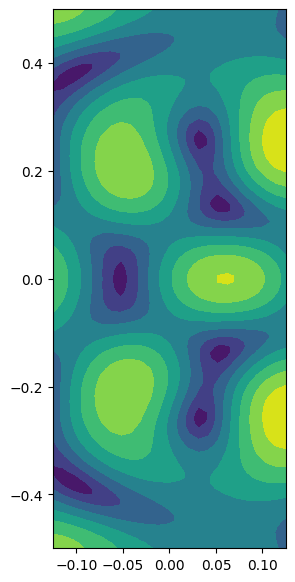

In [4]:
plt.figure(figsize=(3,7))
plt.contourf(X1, Y1, np.absolute(E.reshape(E0.shape)))

In [24]:
# defining the domain
sz = 1                       # µm
x = np.linspace(-sz,sz,100)     
y = np.linspace(-sz,sz,100)     

# areas
dat = ((x[-1] - x[0])*(y[-1] - y[0]))/(len(x)*len(y))
at = np.sqrt(dat/np.pi)                           

X, Y = np.meshgrid(x, y)

E0t = np.exp(1j*k*(X*np.cos(t) + Y*np.sin(t)))

In [25]:
# build the Green function for the whole domain
xtx, xty = X.shape
gtx = xtx*xty
Gt = np.zeros((gtx, g1x), dtype = 'complex_')   # now G is a rectangle

Xf = X.flatten()
Yf = Y.flatten()

for i, xi in enumerate(Xf):
    for j, xj in enumerate(X1f):
        if i==j:
            Gt[i][i] = (-1/(2*1j*((at*k)**2))) * (at*k*hankel1(1, at*k) + ((2*1j)/np.pi))
        else:
            yi, yj = Yf[i], Y1f[j]
            zij = k * np.sqrt((xi - xj)**2 + (yi - yj)**2)
            Gt[i][j] = (-1/(4*1j))*hankel1(0, zij)

Et = E0t.flatten() + k*dat*np.matmul(np.matmul(Gt, e), E)

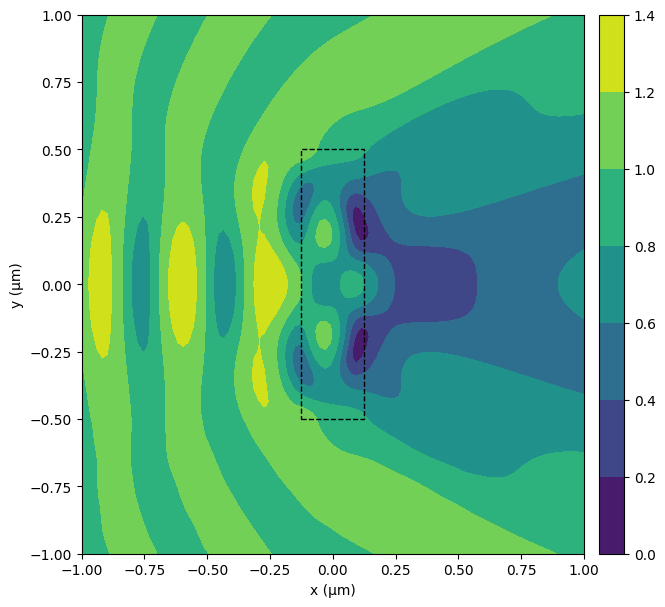

In [18]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(7, 7))

im = ax.contourf(X, Y, np.absolute(Et.reshape(E0t.shape)))
# Create a Rectangle patch
rect = patches.Rectangle((-0.125, -.500), .25, 1, linewidth=1, edgecolor='black', facecolor='none', linestyle='--')

# Add the patch to the Axes
ax.add_patch(rect)
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.15)
fig.colorbar(im, cax=cax, orientation='vertical')

### Big Area $8 \mu m \times 8\mu m$

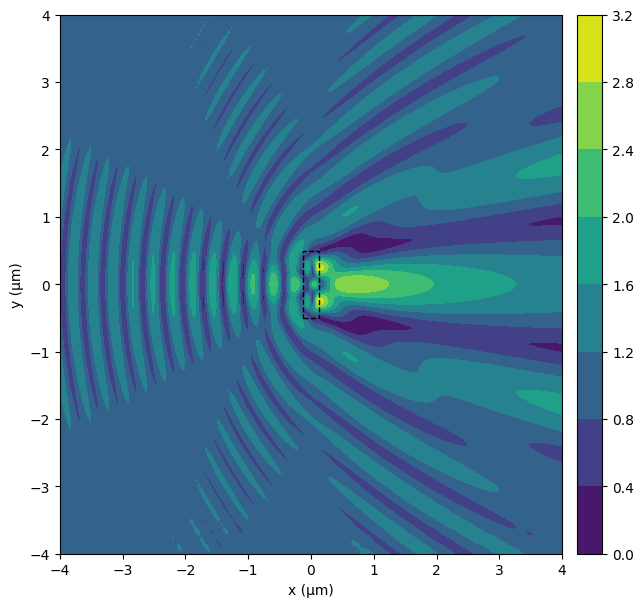

In [19]:
# defining the domain
szb = 4                       # µm
xb = np.linspace(-szb,szb,200)     
yb = np.linspace(-szb,szb,200)     

# areas
datb = ((xb[-1] - xb[0])*(yb[-1] - yb[0]))/(len(xb)*len(yb))
atb = np.sqrt(datb/np.pi)                           

Xb, Yb = np.meshgrid(xb, yb)

E0tb = np.exp(1j*k*(Xb*np.cos(t) + Yb*np.sin(t)))

# build the Green function for the whole domain
xtxb, xtyb = Xb.shape
gtxb = xtxb*xtyb
Gtb = np.zeros((gtxb, g1x), dtype = 'complex_')   # now G is a rectangle

Xbf = Xb.flatten()
Ybf = Yb.flatten()

for i, xi in enumerate(Xbf):
    for j, xj in enumerate(X1f):
        if i==j:
            Gtb[i][i] = (-1/(2*1j*((atb*k)**2))) * (atb*k*hankel1(1, atb*k) + ((2*1j)/np.pi))
        else:
            yi, yj = Ybf[i], Y1f[j]
            zij = k * np.sqrt((xi - xj)**2 + (yi - yj)**2)
            Gtb[i][j] = (-1/(4*1j))*hankel1(0, zij)

Etb = E0tb.flatten() + k*datb*np.matmul(np.matmul(Gtb, e), E)

# Create figure and axes
fig, ax = plt.subplots(figsize=(7, 7))

im = ax.contourf(Xb, Yb, np.absolute(Etb.reshape(E0tb.shape)))
# Create a Rectangle patch
rect = patches.Rectangle((-0.125, -.500), .25, 1, linewidth=1, edgecolor='black', facecolor='none', linestyle='--')

# Add the patch to the Axes
ax.add_patch(rect)
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.15)
fig.colorbar(im, cax=cax, orientation='vertical')

## $45^{\degree}$

### Small Area $2 \mu m \times 2\mu m$

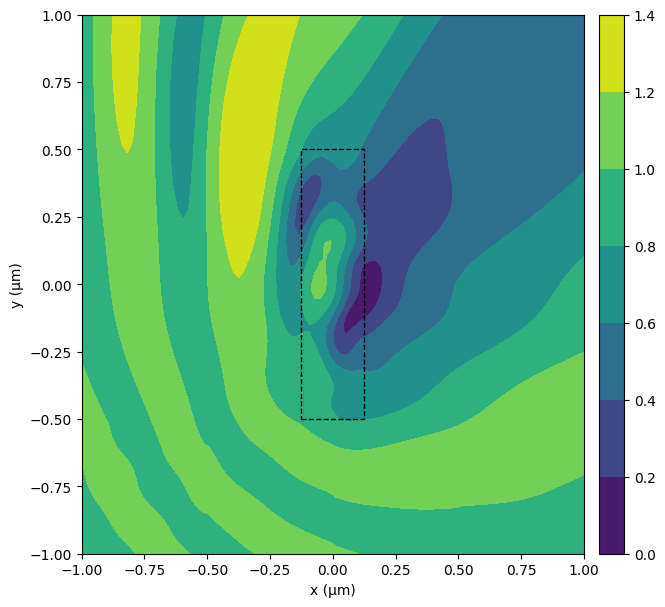

In [26]:
tdeg = 45                 # °
t = (np.pi/180) * tdeg    # rad

E0 = np.exp(1j*k*(X1*np.cos(t) + Y1*np.sin(t)))
E = np.matmul(Minv, E0.flatten())

E0t = np.exp(1j*k*(X*np.cos(t) + Y*np.sin(t)))
Et = E0t.flatten() + k*dat*np.matmul(np.matmul(Gt, e), E)


# Create figure and axes
fig, ax = plt.subplots(figsize=(7, 7))

im = ax.contourf(X, Y, np.absolute(Et.reshape(E0t.shape)))
# Create a Rectangle patch
rect = patches.Rectangle((-0.125, -.500), .25, 1, linewidth=1, edgecolor='black', facecolor='none', linestyle='--')

# Add the patch to the Axes
ax.add_patch(rect)
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.15)
fig.colorbar(im, cax=cax, orientation='vertical')

### Big Area $8 \mu m \times 8\mu m$

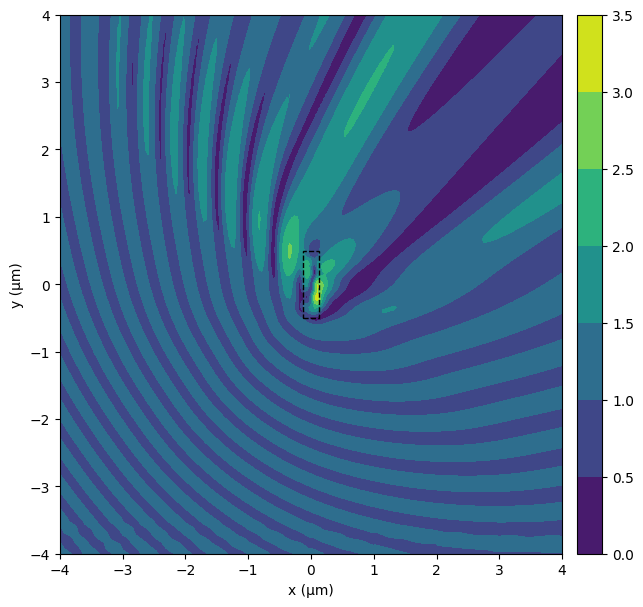

In [21]:
E0 = np.exp(1j*k*(X1*np.cos(t) + Y1*np.sin(t)))
E = np.matmul(Minv, E0.flatten())

E0tb = np.exp(1j*k*(Xb*np.cos(t) + Yb*np.sin(t)))
Etb = E0tb.flatten() + k*datb*np.matmul(np.matmul(Gtb, e), E)


# Create figure and axes
fig, ax = plt.subplots(figsize=(7, 7))

im = ax.contourf(Xb, Yb, np.absolute(Etb.reshape(E0tb.shape)))
# Create a Rectangle patch
rect = patches.Rectangle((-0.125, -.500), .25, 1, linewidth=1, edgecolor='black', facecolor='none', linestyle='--')

# Add the patch to the Axes
ax.add_patch(rect)
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.15)
fig.colorbar(im, cax=cax, orientation='vertical')

# Circle

## $500$ nm diameter

In [2]:
tdeg = 0                  # °
t = (np.pi/180) * tdeg    # rad

# circle dims
d = 0.500                 # µm

### Small area $1.5 \mu m \times 1.5\mu m$

In [29]:
# circle domain
x1 = np.linspace(-d/2, d/2, 10)                   
y1 = np.linspace(-d/2, d/2, 10) 

# areas
da = ((x1[-1] - x1[0])*(y1[-1] - y1[0]))/(len(x1)*len(y1)) 
a = np.sqrt(da/np.pi)  

X1, Y1 = np.meshgrid(x1, y1)
mask = (X1)**2 + (Y1)**2 <= (d/2)**2

k = np.sqrt(eref)*k0
E0 = np.exp(1j*k*(X1*np.cos(t) + Y1*np.sin(t)))

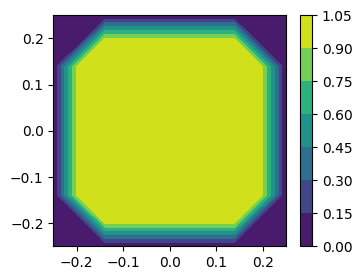

In [30]:
mf = mask.flatten()
plt.figure(figsize=(3.75,3))
plt.contourf(X1, Y1, (np.ones(len(mf))*mf).reshape((len(X1), len(X1))))
plt.colorbar()

In [31]:
# build the Green function for the bare rectangle
x1x, x1y = X1.shape
g1x = x1x*x1y
G = np.zeros((g1x, g1x), dtype = 'complex_')

X1f = X1.flatten()
Y1f = Y1.flatten()
mf = mask.flatten()

for i, xi in enumerate(X1f):
    for j, xj in enumerate(X1f):
        mj = int(mf[j])
        if i==j:
            G[i][i] = (-1/(2*1j*((a*k)**2))) * (a*k*hankel1(1, a*k) + ((2*1j)/np.pi)) * mj
        else:
            yi, yj = Y1f[i], Y1f[j]
            zij = k * np.sqrt((xi - xj)**2 + (yi - yj)**2)
            G[i][j] = (-1/(4*1j)) * hankel1(0, zij) * mj        # the circular mask is now "chopping" the output matrix

# dielectric function in the rectangle
e = (e1-eref)*np.eye(g1x)

# use eq. (9) to calculate the field inside the structure
I = np.identity(g1x)
M = sparse.csr_matrix(I - (k**2)*da*np.matmul(G, e))
Minv = np.linalg.pinv(M.toarray())
E = np.matmul(Minv, E0.flatten()) * mf

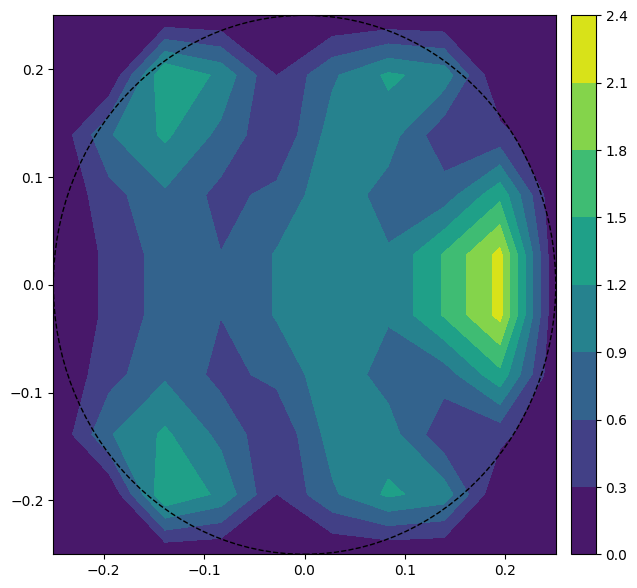

In [40]:
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.contourf(X1, Y1, np.absolute(E.reshape(E0.shape)))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.15)
fig.colorbar(im, cax=cax, orientation='vertical')
rect = patches.Circle((0, 0), d/2, linewidth=1, edgecolor='black', facecolor='none', linestyle='--')
# Add the patch to the Axes
ax.add_patch(rect)
plt.show()

In [33]:
# defining the domain
sz = 1.5                            # µm
x = np.linspace(-sz/2, sz/2, 800)     
y = np.linspace(-sz/2, sz/2, 800)     

# areas
dat = ((x[-1] - x[0])*(y[-1] - y[0]))/(len(x)*len(y))
at = np.sqrt(dat/np.pi)                           

X, Y = np.meshgrid(x, y)

E0t = np.exp(1j*k*(X*np.cos(t) + Y*np.sin(t)))

In [34]:
# build the Green function for the whole domain
xtx, xty = X.shape
gtx = xtx*xty
Gt = np.zeros((gtx, g1x), dtype = 'complex_')   # now G is a rectangle

Xf = X.flatten()
Yf = Y.flatten()

for i, xi in enumerate(Xf):
    for j, xj in enumerate(X1f):
        if i==j:
            Gt[i][i] = (-1/(2*1j*((at*k)**2))) * (at*k*hankel1(1, at*k) + ((2*1j)/np.pi))
        else:
            yi, yj = Yf[i], Y1f[j]
            zij = k * np.sqrt((xi - xj)**2 + (yi - yj)**2)
            Gt[i][j] = (-1/(4*1j)) * hankel1(0, zij)

Et = E0t.flatten() + k*dat*np.matmul(np.matmul(Gt, e), E)

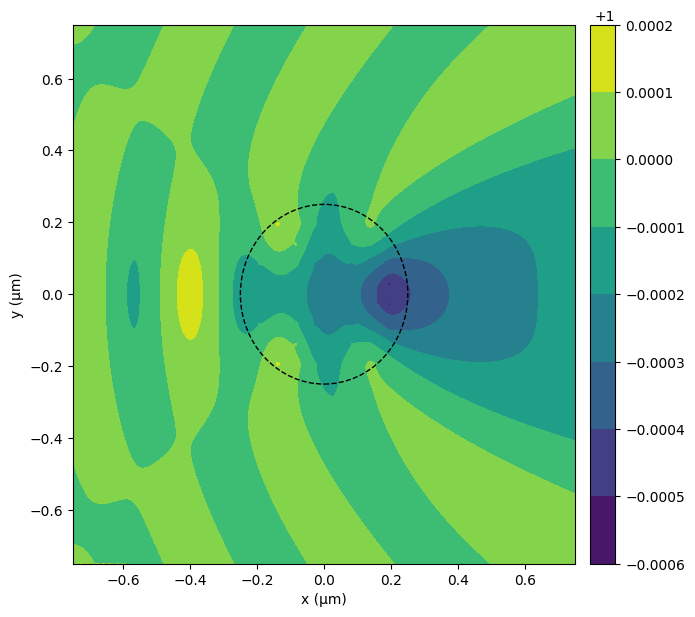

In [46]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(7, 7))

im = ax.contourf(X, Y, np.absolute(Et.reshape(E0t.shape)))
# Create a Circle patch
rect = patches.Circle((0, 0), d/2, linewidth=1, edgecolor='black', facecolor='none', linestyle='--')

# Add the patch to the Axes
ax.add_patch(rect)
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.15)
fig.colorbar(im, cax=cax, orientation='vertical')

### Big Area $6 \mu m \times 6\mu m$

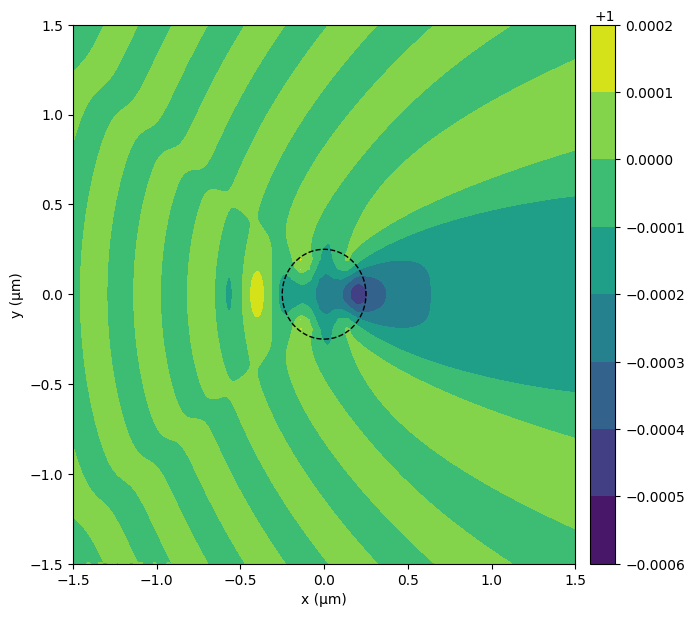

In [47]:
# defining the domain
szb = 3                            # µm
xb = np.linspace(-sz, sz, 400)     
yb = np.linspace(-sz, sz, 400)     

# areas
datb = ((x[-1] - x[0])*(y[-1] - y[0]))/(len(x)*len(y))
atb = np.sqrt(datb/np.pi)                           

Xb, Yb = np.meshgrid(xb, yb)

E0tb = np.exp(1j*k*(Xb*np.cos(t) + Yb*np.sin(t)))

# build the Green function for the whole domain
xtxb, xtyb = Xb.shape
gtxb = xtxb*xtyb
Gtb = np.zeros((gtxb, g1x), dtype = 'complex_')   # now G is a rectangle

Xbf = Xb.flatten()
Ybf = Yb.flatten()

for i, xi in enumerate(Xbf):
    for j, xj in enumerate(X1f):
        if i==j:
            Gtb[i][i] = (-1/(2*1j*((atb*k)**2))) * (atb*k*hankel1(1, atb*k) + ((2*1j)/np.pi))
        else:
            yi, yj = Ybf[i], Y1f[j]
            zij = k * np.sqrt((xi - xj)**2 + (yi - yj)**2)
            Gtb[i][j] = (-1/(4*1j))*hankel1(0, zij)

Etb = E0tb.flatten() + k*datb*np.matmul(np.matmul(Gtb, e), E)

# Create figure and axes
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.contourf(Xb, Yb, np.absolute(Etb.reshape(E0tb.shape)))

# Create a Circle patch
rect = patches.Circle((0, 0), d/2, linewidth=1, edgecolor='black', facecolor='none', linestyle='--')

# Add the patch to the Axes
ax.add_patch(rect)
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.15)
fig.colorbar(im, cax=cax, orientation='vertical')

## $100$ nm diameter

In [49]:
# circle dims
d = 0.100                 # µm

### Small area $1.5 \mu m \times 1.5\mu m$

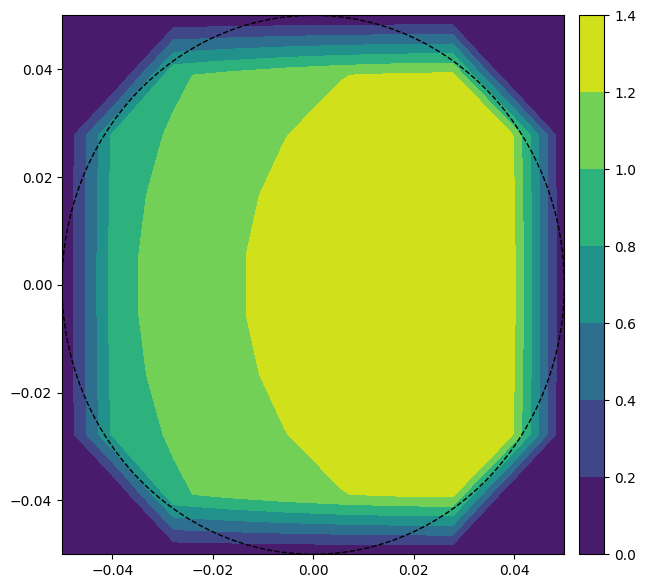

In [50]:
# circle domain
x1 = np.linspace(-d/2, d/2, 10)                   
y1 = np.linspace(-d/2, d/2, 10) 

# areas
da = ((x1[-1] - x1[0])*(y1[-1] - y1[0]))/(len(x1)*len(y1)) 
a = np.sqrt(da/np.pi)  

X1, Y1 = np.meshgrid(x1, y1)
mask = (X1)**2 + (Y1)**2 <= (d/2)**2

k = np.sqrt(eref)*k0
E0 = np.exp(1j*k*(X1*np.cos(t) + Y1*np.sin(t)))

# build the Green function for the bare rectangle
x1x, x1y = X1.shape
g1x = x1x*x1y
G = np.zeros((g1x, g1x), dtype = 'complex_')

X1f = X1.flatten()
Y1f = Y1.flatten()
mf = mask.flatten()

for i, xi in enumerate(X1f):
    for j, xj in enumerate(X1f):
        mj = int(mf[j])
        if i==j:
            G[i][i] = (-1/(2*1j*((a*k)**2))) * (a*k*hankel1(1, a*k) + ((2*1j)/np.pi)) * mj
        else:
            yi, yj = Y1f[i], Y1f[j]
            zij = k * np.sqrt((xi - xj)**2 + (yi - yj)**2)
            G[i][j] = (-1/(4*1j)) * hankel1(0, zij) * mj        # the circular mask is now "chopping" the output matrix

# dielectric function in the rectangle
e = (e1-eref)*np.eye(g1x)

# use eq. (9) to calculate the field inside the structure
I = np.identity(g1x)
M = sparse.csr_matrix(I - (k**2)*da*np.matmul(G, e))
Minv = np.linalg.pinv(M.toarray())
E = np.matmul(Minv, E0.flatten()) * mf

fig, ax = plt.subplots(figsize=(7, 7))
im = ax.contourf(X1, Y1, np.absolute(E.reshape(E0.shape)))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.15)
fig.colorbar(im, cax=cax, orientation='vertical')
rect = patches.Circle((0, 0), d/2, linewidth=1, edgecolor='black', facecolor='none', linestyle='--')
# Add the patch to the Axes
ax.add_patch(rect)
plt.show()

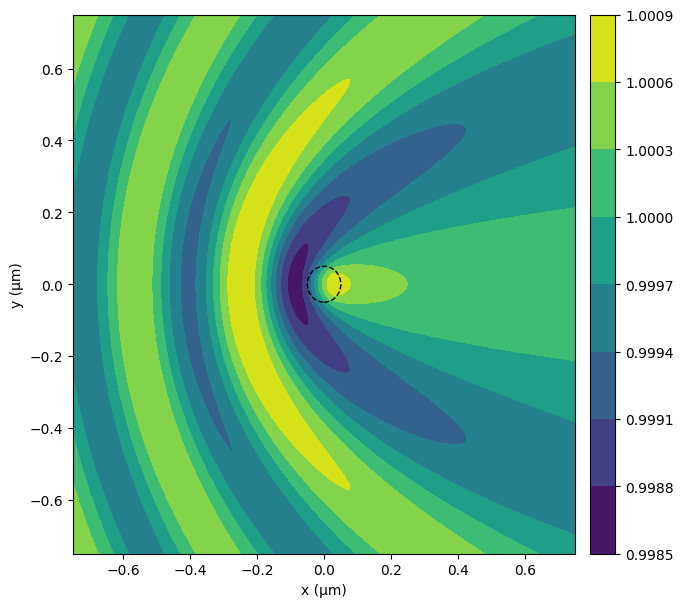

In [51]:
# defining the domain
sz = 1.5                            # µm
x = np.linspace(-sz/2, sz/2, 800)     
y = np.linspace(-sz/2, sz/2, 800)     

# areas
dat = ((x[-1] - x[0])*(y[-1] - y[0]))/(len(x)*len(y))
at = np.sqrt(dat/np.pi)                           

X, Y = np.meshgrid(x, y)

E0t = np.exp(1j*k*(X*np.cos(t) + Y*np.sin(t)))

# build the Green function for the whole domain
xtx, xty = X.shape
gtx = xtx*xty
Gt = np.zeros((gtx, g1x), dtype = 'complex_')   # now G is a rectangle

Xf = X.flatten()
Yf = Y.flatten()

for i, xi in enumerate(Xf):
    for j, xj in enumerate(X1f):
        if i==j:
            Gt[i][i] = (-1/(2*1j*((at*k)**2))) * (at*k*hankel1(1, at*k) + ((2*1j)/np.pi))
        else:
            yi, yj = Yf[i], Y1f[j]
            zij = k * np.sqrt((xi - xj)**2 + (yi - yj)**2)
            Gt[i][j] = (-1/(4*1j)) * hankel1(0, zij)

Et = E0t.flatten() + k*dat*np.matmul(np.matmul(Gt, e), E)

# Create figure and axes
fig, ax = plt.subplots(figsize=(7, 7))

im = ax.contourf(X, Y, np.absolute(Et.reshape(E0t.shape)))
# Create a Circle patch
rect = patches.Circle((0, 0), d/2, linewidth=1, edgecolor='black', facecolor='none', linestyle='--')

# Add the patch to the Axes
ax.add_patch(rect)
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.15)
fig.colorbar(im, cax=cax, orientation='vertical')

### Big Area $6 \mu m \times 6\mu m$

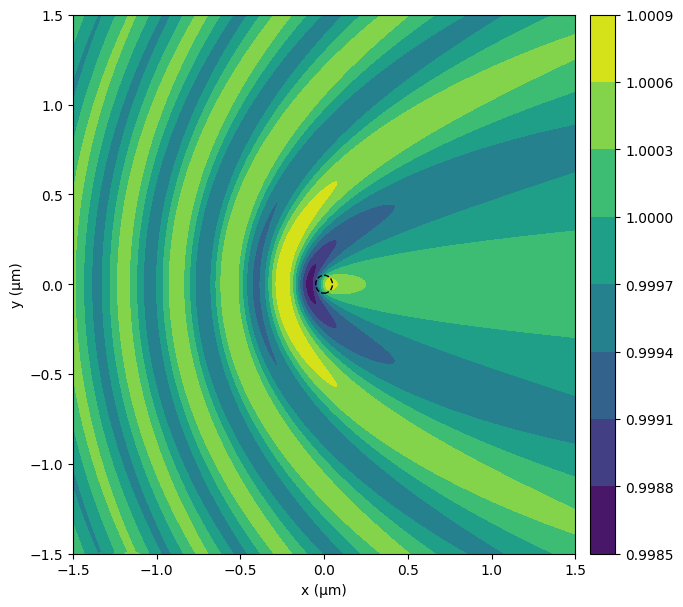

In [52]:
# defining the domain
szb = 3                            # µm
xb = np.linspace(-sz, sz, 400)     
yb = np.linspace(-sz, sz, 400)     

# areas
datb = ((x[-1] - x[0])*(y[-1] - y[0]))/(len(x)*len(y))
atb = np.sqrt(datb/np.pi)                           

Xb, Yb = np.meshgrid(xb, yb)

E0tb = np.exp(1j*k*(Xb*np.cos(t) + Yb*np.sin(t)))

# build the Green function for the whole domain
xtxb, xtyb = Xb.shape
gtxb = xtxb*xtyb
Gtb = np.zeros((gtxb, g1x), dtype = 'complex_')   # now G is a rectangle

Xbf = Xb.flatten()
Ybf = Yb.flatten()

for i, xi in enumerate(Xbf):
    for j, xj in enumerate(X1f):
        if i==j:
            Gtb[i][i] = (-1/(2*1j*((atb*k)**2))) * (atb*k*hankel1(1, atb*k) + ((2*1j)/np.pi))
        else:
            yi, yj = Ybf[i], Y1f[j]
            zij = k * np.sqrt((xi - xj)**2 + (yi - yj)**2)
            Gtb[i][j] = (-1/(4*1j))*hankel1(0, zij)

Etb = E0tb.flatten() + k*datb*np.matmul(np.matmul(Gtb, e), E)

# Create figure and axes
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.contourf(Xb, Yb, np.absolute(Etb.reshape(E0tb.shape)))

# Create a Circle patch
rect = patches.Circle((0, 0), d/2, linewidth=1, edgecolor='black', facecolor='none', linestyle='--')

# Add the patch to the Axes
ax.add_patch(rect)
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.15)
fig.colorbar(im, cax=cax, orientation='vertical')